In [1]:
# Cell 1 — Imports + paths + reproducibility
import os, json, time
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional

# ---- paths ----
DATA_PROC = "/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed"
OUT_DIR = os.path.join(DATA_PROC, "network_sindy_out_Sch200")
os.makedirs(OUT_DIR, exist_ok=True)

# ---- reproducibility ----
SEED = 0
rng = np.random.default_rng(SEED)

print("DATA_PROC:", DATA_PROC)
print("OUT_DIR:", OUT_DIR)
print("SEED:", SEED)


DATA_PROC: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed
OUT_DIR: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200
SEED: 0


In [2]:
# Cell 2 — Config (single source of truth) + auto-save helper

@dataclass
class NetSINDyConfig:
    # data
    parc_name: str = "Sch200"
    system: str = "hopf"          # "hopf" or "diff"
    X_file: str = "Y_hopf_Sch200.npy"
    W_file: str = "W_Sch200_empirical.npy"
    dt: float = 0.02              # Hopf dt from your simulator; use dt=1.0 for diffusion if discrete steps

    # delays
    delay_type: str = "global"
    tau_samples: int = 0          # global delay in samples (0,1,2,3,...)

    # SINDy library (start conservative)
    include_constant: bool = True
    include_local_linear: bool = True
    include_local_cubic: bool = True
    include_network_linear: bool = True  # W_ij * x_j(t-tau)

    # sparse regression
    lam: float = 1e-4
    stlsq_iters: int = 10

    # validation
    train_frac: float = 0.7
    val_T_plot: int = 1200        # how many timesteps to plot in validation figures

    # bookkeeping
    timestamp: str = ""           # auto-filled when saving

def save_config(cfg: NetSINDyConfig, out_dir: str) -> str:
    cfg.timestamp = time.strftime("%Y-%m-%d_%H%M%S")
    cfg_path = os.path.join(out_dir, f"config_network_sindy_{cfg.parc_name}_{cfg.system}_{cfg.timestamp}.json")
    with open(cfg_path, "w") as f:
        json.dump(asdict(cfg), f, indent=2)
    print("Saved config:", cfg_path)
    return cfg_path

def save_fig(name: str, out_dir: str):
    path = os.path.join(out_dir, name)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved figure:", path)

# ---- choose your run settings here ----
cfg = NetSINDyConfig(
    system="hopf",
    X_file="Y_hopf_Sch200.npy",
    W_file="W_Sch200_empirical.npy",
    dt=0.02,          # IMPORTANT: keep consistent with Hopf simulation
    tau_samples=2,    # global delay (in samples)
    lam=1e-4
)

cfg_path = save_config(cfg, OUT_DIR)


Saved config: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/config_network_sindy_Sch200_hopf_2026-01-01_085748.json


In [3]:
# Cell 3 — Load X(t) and W, standardize, build delayed X_tau, and save core inputs used

# ---- load ----
X_raw = np.load(os.path.join(DATA_PROC, cfg.X_file))   # expected shape either (N, T) or (T, N)
W = np.load(os.path.join(DATA_PROC, cfg.W_file))       # (N, N)

# ---- make X as (T, N) ----
if X_raw.ndim != 2:
    raise ValueError(f"Expected 2D array for X, got shape {X_raw.shape}")

if X_raw.shape[0] == W.shape[0]:
    # X is (N, T) -> transpose
    X = X_raw.T
elif X_raw.shape[1] == W.shape[0]:
    # X is (T, N) -> keep
    X = X_raw
else:
    raise ValueError(f"X shape {X_raw.shape} does not match W shape {W.shape}")

T, N = X.shape
print("X shape (T, N):", X.shape)
print("W shape:", W.shape)

# ---- z-score each ROI across time ----
eps = 1e-12
X_mu = X.mean(axis=0, keepdims=True)
X_sd = X.std(axis=0, keepdims=True)
Xz = (X - X_mu) / (X_sd + eps)

# ---- global delay in samples ----
tau = int(cfg.tau_samples)
if tau < 0:
    raise ValueError("tau_samples must be >= 0")

# align so that (t) and (t-tau) are valid
# we will later compute derivatives; for now just build delayed version aligned with Xz
if tau == 0:
    X_tau = Xz.copy()
    t0 = 0
else:
    X_tau = Xz[:-tau, :]          # (T - tau, N) corresponds to x(t)
    Xz = Xz[tau:, :]              # shift x(t) to align with x(t-tau)
    t0 = tau

print("After delay alignment:")
print("Xz (aligned) shape:", Xz.shape)       # (T - tau, N)
print("X_tau shape:", X_tau.shape)           # (T - tau, N)

# ---- save exactly what will be used downstream ----
np.save(os.path.join(OUT_DIR, "X_used.npy"), Xz)
np.save(os.path.join(OUT_DIR, "X_tau_used.npy"), X_tau)
np.save(os.path.join(OUT_DIR, "W_used.npy"), W)
np.save(os.path.join(OUT_DIR, "X_mean.npy"), X_mu)
np.save(os.path.join(OUT_DIR, "X_std.npy"), X_sd)

print("Saved core inputs: X_used.npy, X_tau_used.npy, W_used.npy, X_mean.npy, X_std.npy")


X shape (T, N): (20000, 200)
W shape: (200, 200)
After delay alignment:
Xz (aligned) shape: (19998, 200)
X_tau shape: (19998, 200)
Saved core inputs: X_used.npy, X_tau_used.npy, W_used.npy, X_mean.npy, X_std.npy


In [4]:
# Cell 4 — Derivatives + train/val split (aligned with delays already applied)

def finite_difference_centered(X: np.ndarray, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Central difference: dX/dt at interior points.
    Returns:
        X_mid: (T-2, N)
        dXdt:  (T-2, N)
    """
    dXdt = (X[2:] - X[:-2]) / (2.0 * dt)
    X_mid = X[1:-1]
    return X_mid, dXdt

# Xz and X_tau are already aligned in Cell 3:
#   Xz[t] corresponds to x(t)
#   X_tau[t] corresponds to x(t - tau)
X_mid, dXdt = finite_difference_centered(Xz, cfg.dt)
Xtau_mid = X_tau[1:-1]  # align delayed predictors with X_mid/dXdt

print("X_mid:", X_mid.shape, "dXdt:", dXdt.shape, "Xtau_mid:", Xtau_mid.shape)

# Save derivatives used
np.save(os.path.join(OUT_DIR, "dXdt_used.npy"), dXdt)

def time_split(Xm: np.ndarray, Xtau: np.ndarray, dX: np.ndarray, train_frac: float):
    T = Xm.shape[0]
    n_tr = int(train_frac * T)
    return (Xm[:n_tr], Xtau[:n_tr], dX[:n_tr]), (Xm[n_tr:], Xtau[n_tr:], dX[n_tr:])

(X_tr, Xtau_tr, dX_tr), (X_va, Xtau_va, dX_va) = time_split(X_mid, Xtau_mid, dXdt, cfg.train_frac)

print("Train:", X_tr.shape, Xtau_tr.shape, dX_tr.shape)
print("Val:  ", X_va.shape, Xtau_va.shape, dX_va.shape)


X_mid: (19996, 200) dXdt: (19996, 200) Xtau_mid: (19996, 200)
Train: (13997, 200) (13997, 200) (13997, 200)
Val:   (5999, 200) (5999, 200) (5999, 200)


In [5]:
# Cell 5 — Build node-wise library Θ_i and a fast builder for all nodes

def build_theta_for_node(i: int,
                         X: np.ndarray,
                         Xtau: np.ndarray,
                         W: np.ndarray,
                         cfg: NetSINDyConfig) -> Tuple[np.ndarray, List[str]]:
    """
    Build Θ_i for node i.
    Columns (conservative):
      1 (optional)
      x_i (optional)
      x_i^3 (optional)
      W_ij * x_j(t-tau) for all j (optional)
    Shapes:
      X, Xtau: (T, N)
      returns Theta: (T, n_features)
    """
    T, N = X.shape
    cols = []
    names = []

    if cfg.include_constant:
        cols.append(np.ones((T, 1)))
        names.append("1")

    if cfg.include_local_linear:
        cols.append(X[:, [i]])
        names.append(f"x{i}")

    if cfg.include_local_cubic:
        cols.append((X[:, [i]] ** 3))
        names.append(f"x{i}^3")

    if cfg.include_network_linear:
        # network drive terms: W_ij * x_j(t-tau) for each j
        drive = Xtau * W[i, :][None, :]  # (T, N)
        cols.append(drive)
        names += [f"W{i},{j}*x{j}(t-tau)" for j in range(N)]

    Theta = np.concatenate(cols, axis=1)
    return Theta, names

# Quick check feature count for node 0
Theta0, names0 = build_theta_for_node(0, X_tr, Xtau_tr, W, cfg)
print("Theta(node0) shape:", Theta0.shape, "n_features:", len(names0))
print("First 5 features:", names0[:5])


Theta(node0) shape: (13997, 203) n_features: 203
First 5 features: ['1', 'x0', 'x0^3', 'W0,0*x0(t-tau)', 'W0,1*x1(t-tau)']


In [6]:
# Cell 6 — STLSQ optimizer (reused, but per-node scalar regression)

def stlsq_scalar(Theta: np.ndarray, y: np.ndarray, lam: float, n_iter: int = 10) -> np.ndarray:
    """
    STLSQ for a single target y (T,).
    Returns xi: (n_features,)
    """
    xi, *_ = np.linalg.lstsq(Theta, y, rcond=None)

    for _ in range(n_iter):
        small = np.abs(xi) < lam
        xi[small] = 0.0

        active = ~small
        if active.sum() == 0:
            break

        xi_active, *_ = np.linalg.lstsq(Theta[:, active], y, rcond=None)
        xi[active] = xi_active

    return xi

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean((y_true - y_pred)**2))

def nnz_vec(x: np.ndarray) -> int:
    return int(np.sum(np.abs(x) > 0))


In [7]:
# Cell 7 — Fit all nodes for a given λ, return Xi and metrics

def fit_all_nodes(lam: float,
                  Xtr: np.ndarray, Xtau_tr: np.ndarray, dXtr: np.ndarray,
                  Xva: np.ndarray, Xtau_va: np.ndarray, dXva: np.ndarray,
                  W: np.ndarray, cfg: NetSINDyConfig):
    """
    Fit per-node equations for dx_i/dt.
    Returns:
      Xi: (N, n_features_i) but n_features_i is same for all i with this library.
      names: feature names
      metrics: dict with train/val mse and nnz summaries
    """
    N = Xtr.shape[1]

    # Build names once (they are same structure for all i, but include i in labels)
    Theta_tmp, names = build_theta_for_node(0, Xtr, Xtau_tr, W, cfg)
    n_features = Theta_tmp.shape[1]

    Xi = np.zeros((N, n_features))
    tr_mse = np.zeros(N)
    va_mse = np.zeros(N)
    nnz_per_node = np.zeros(N, dtype=int)

    for i in range(N):
        Theta_i_tr, _ = build_theta_for_node(i, Xtr, Xtau_tr, W, cfg)
        Theta_i_va, _ = build_theta_for_node(i, Xva, Xtau_va, W, cfg)

        y_tr = dXtr[:, i]
        y_va = dXva[:, i]

        xi = stlsq_scalar(Theta_i_tr, y_tr, lam=lam, n_iter=cfg.stlsq_iters)
        Xi[i, :] = xi

        tr_mse[i] = mse(y_tr, Theta_i_tr @ xi)
        va_mse[i] = mse(y_va, Theta_i_va @ xi)
        nnz_per_node[i] = nnz_vec(xi)

    metrics = {
        "lam": float(lam),
        "train_mse_mean": float(tr_mse.mean()),
        "val_mse_mean": float(va_mse.mean()),
        "nnz_mean": float(nnz_per_node.mean()),
        "nnz_median": float(np.median(nnz_per_node)),
        "nnz_max": int(nnz_per_node.max()),
        "nnz_per_node": nnz_per_node.tolist()
    }
    return Xi, names, metrics

# Example single fit
Xi_test, names_test, metrics_test = fit_all_nodes(
    lam=cfg.lam,
    Xtr=X_tr, Xtau_tr=Xtau_tr, dXtr=dX_tr,
    Xva=X_va, Xtau_va=Xtau_va, dXva=dX_va,
    W=W, cfg=cfg
)
print(metrics_test)
print("Xi_test shape:", Xi_test.shape)


{'lam': 0.0001, 'train_mse_mean': 0.012410460251017566, 'val_mse_mean': 0.060714697178142, 'nnz_mean': 17.93, 'nnz_median': 17.0, 'nnz_max': 42, 'nnz_per_node': [14, 18, 13, 12, 14, 10, 32, 12, 21, 18, 31, 16, 31, 32, 13, 17, 21, 26, 8, 20, 27, 7, 17, 16, 20, 27, 16, 16, 25, 13, 16, 20, 15, 12, 14, 20, 31, 13, 14, 30, 17, 11, 17, 15, 17, 12, 28, 9, 9, 24, 39, 18, 18, 19, 10, 17, 25, 25, 10, 12, 21, 12, 11, 18, 10, 22, 10, 34, 22, 19, 24, 16, 13, 22, 20, 24, 15, 18, 11, 34, 12, 20, 12, 8, 24, 26, 36, 13, 37, 19, 42, 17, 32, 14, 32, 21, 10, 14, 11, 23, 18, 22, 14, 17, 9, 24, 15, 11, 17, 16, 7, 19, 13, 29, 16, 19, 9, 15, 12, 13, 6, 10, 11, 12, 12, 8, 11, 15, 24, 25, 16, 16, 16, 9, 12, 9, 8, 17, 15, 23, 25, 33, 23, 41, 13, 16, 21, 13, 8, 24, 15, 17, 25, 9, 19, 18, 20, 20, 12, 12, 24, 12, 21, 12, 17, 8, 14, 10, 10, 15, 29, 18, 24, 28, 20, 29, 18, 22, 19, 15, 11, 13, 13, 21, 11, 7, 8, 11, 11, 25, 18, 15, 14, 28, 37, 10, 27, 25, 25, 18]}
Xi_test shape: (200, 203)


In [8]:
# Cell 8 — λ sweep + select best model (simple + good val) + save Xi_best.npy

lam_grid = np.logspace(-8, -2, 13)  # adjust later if needed
all_metrics = []
all_Xi = []

for lam in lam_grid:
    Xi, names, met = fit_all_nodes(
        lam=lam,
        Xtr=X_tr, Xtau_tr=Xtau_tr, dXtr=dX_tr,
        Xva=X_va, Xtau_va=Xtau_va, dXva=dX_va,
        W=W, cfg=cfg
    )
    all_metrics.append(met)
    all_Xi.append(Xi)
    print(f"lam={lam:.1e}  val_mse_mean={met['val_mse_mean']:.3e}  nnz_mean={met['nnz_mean']:.1f}  nnz_max={met['nnz_max']}")

# Selection rule:
# Pick the model with lowest val MSE among those with near-minimal nnz_mean.
val_mses = np.array([m["val_mse_mean"] for m in all_metrics])
nnz_means = np.array([m["nnz_mean"] for m in all_metrics])

best_val = val_mses.min()
# allow within 5% of best val, then pick sparsest among those
good = val_mses <= (1.05 * best_val)
idx_best = np.where(good)[0][np.argmin(nnz_means[good])]

Xi_best = all_Xi[idx_best]
metrics_best = all_metrics[idx_best]

print("\nSelected model:")
print(metrics_best)

# Save
np.save(os.path.join(OUT_DIR, "Xi_best.npy"), Xi_best)
with open(os.path.join(OUT_DIR, "sweep_metrics.json"), "w") as f:
    json.dump({"lam_grid": [float(l) for l in lam_grid], "metrics": all_metrics}, f, indent=2)

print("Saved Xi_best.npy and sweep_metrics.json")


lam=1.0e-08  val_mse_mean=6.070e-02  nnz_mean=18.3  nnz_max=43
lam=3.2e-08  val_mse_mean=6.070e-02  nnz_mean=18.3  nnz_max=43
lam=1.0e-07  val_mse_mean=6.070e-02  nnz_mean=18.3  nnz_max=43
lam=3.2e-07  val_mse_mean=6.070e-02  nnz_mean=18.3  nnz_max=43
lam=1.0e-06  val_mse_mean=6.070e-02  nnz_mean=18.3  nnz_max=43
lam=3.2e-06  val_mse_mean=6.070e-02  nnz_mean=18.3  nnz_max=43
lam=1.0e-05  val_mse_mean=6.070e-02  nnz_mean=18.3  nnz_max=43
lam=3.2e-05  val_mse_mean=6.070e-02  nnz_mean=18.2  nnz_max=42
lam=1.0e-04  val_mse_mean=6.071e-02  nnz_mean=17.9  nnz_max=42
lam=3.2e-04  val_mse_mean=6.069e-02  nnz_mean=17.1  nnz_max=38
lam=1.0e-03  val_mse_mean=6.143e-02  nnz_mean=15.3  nnz_max=36
lam=3.2e-03  val_mse_mean=6.804e-02  nnz_mean=11.0  nnz_max=29
lam=1.0e-02  val_mse_mean=7.935e-02  nnz_mean=6.5  nnz_max=22

Selected model:
{'lam': 0.001, 'train_mse_mean': 0.012698585889511484, 'val_mse_mean': 0.06142552926631632, 'nnz_mean': 15.31, 'nnz_median': 15.0, 'nnz_max': 36, 'nnz_per_node': [10

In [9]:
# Cell 9 — Build effective coupling matrix W_hat from Xi_best + save W_hat.npy

def extract_W_hat(Xi: np.ndarray, cfg: NetSINDyConfig, N: int) -> np.ndarray:
    """
    Extract an effective coupling matrix from Xi.
    We assume the feature order is:
      [1?], [x_i?], [x_i^3?], then N network terms (W_ij * x_j(t-tau)) for j=0..N-1
    W_hat[i,j] = coefficient multiplying (W_ij * x_j(t-tau))
    """
    offset = 0
    if cfg.include_constant: offset += 1
    if cfg.include_local_linear: offset += 1
    if cfg.include_local_cubic: offset += 1

    if not cfg.include_network_linear:
        return np.zeros((N, N))

    # Xi: (N, n_features)
    # network block is Xi[:, offset:offset+N]
    W_hat = Xi[:, offset:offset+N].copy()
    return W_hat

W_hat = extract_W_hat(Xi_best, cfg, N=N)
np.save(os.path.join(OUT_DIR, "W_hat.npy"), W_hat)

print("W_hat shape:", W_hat.shape)
print("Saved W_hat.npy")


W_hat shape: (200, 200)
Saved W_hat.npy


Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/nnz_per_node.png


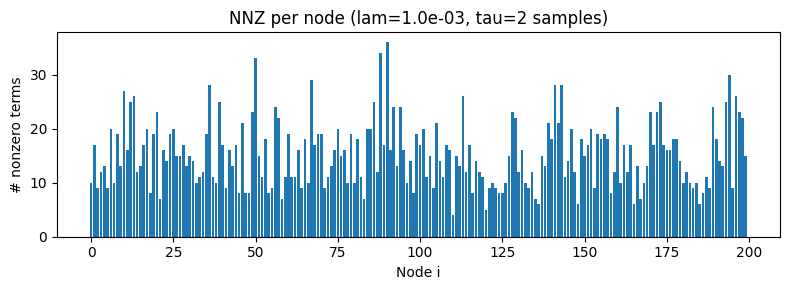

Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/W_vs_What_scatter.png


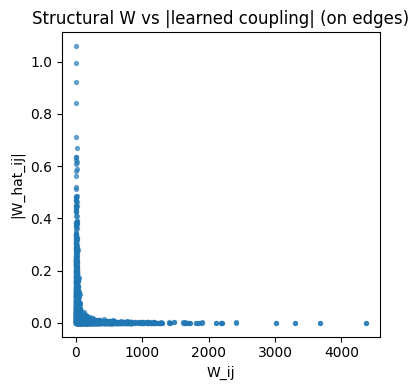

Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/one_step_deriv_node110.png


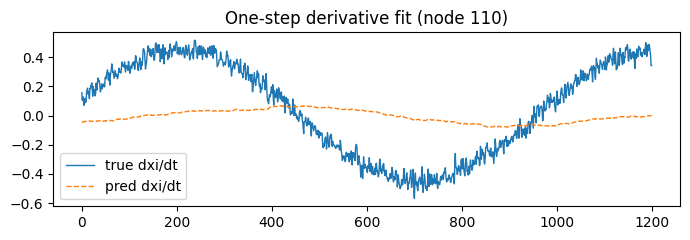

Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/one_step_deriv_node51.png


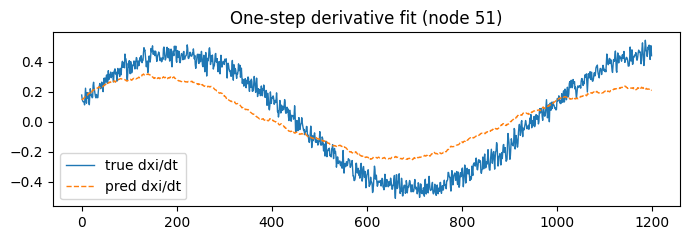

Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/one_step_deriv_node90.png


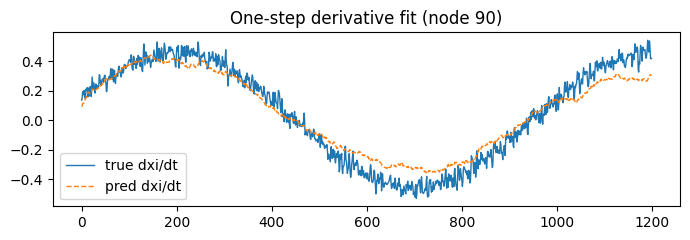

Saved validation plots to OUT_DIR.


In [10]:
# Cell 10 — Validation plots (auto-save): nnz per node, W vs W_hat, one-step prediction for a few nodes

# ---- 10A: nnz per node ----
nnz_per_node = np.array(metrics_best["nnz_per_node"])

plt.figure(figsize=(8,3))
plt.bar(np.arange(N), nnz_per_node)
plt.title(f"NNZ per node (lam={metrics_best['lam']:.1e}, tau={cfg.tau_samples} samples)")
plt.xlabel("Node i")
plt.ylabel("# nonzero terms")
plt.tight_layout()
save_fig("nnz_per_node.png", OUT_DIR)
plt.show()

# ---- 10B: compare W and W_hat (scatter on existing edges) ----
mask = (W != 0)
w_vals = W[mask].ravel()
what_vals = np.abs(W_hat[mask].ravel())

plt.figure(figsize=(4,4))
plt.scatter(w_vals, what_vals, s=8, alpha=0.6)
plt.title("Structural W vs |learned coupling| (on edges)")
plt.xlabel("W_ij")
plt.ylabel("|W_hat_ij|")
plt.tight_layout()
save_fig("W_vs_What_scatter.png", OUT_DIR)
plt.show()

# ---- 10C: one-step derivative prediction on validation for a few nodes ----
# Choose 3 nodes: one with high nnz, one median, one low
order = np.argsort(nnz_per_node)
idx_low = order[0]
idx_med = order[len(order)//2]
idx_high = order[-1]
nodes_to_plot = [idx_low, idx_med, idx_high]

Tplot = min(cfg.val_T_plot, X_va.shape[0])

for i in nodes_to_plot:
    Theta_i_va, _ = build_theta_for_node(i, X_va[:Tplot], Xtau_va[:Tplot], W, cfg)
    y_true = dX_va[:Tplot, i]
    y_pred = Theta_i_va @ Xi_best[i, :]

    plt.figure(figsize=(7,2.5))
    plt.plot(y_true, label="true dxi/dt", lw=1)
    plt.plot(y_pred, "--", label="pred dxi/dt", lw=1)
    plt.title(f"One-step derivative fit (node {i})")
    plt.legend()
    plt.tight_layout()
    save_fig(f"one_step_deriv_node{i}.png", OUT_DIR)
    plt.show()

print("Saved validation plots to OUT_DIR.")


tau=0  best_lam=1.0e-03  best_val_mse=0.0644  nnz_mean=15.3
tau=1  best_lam=1.0e-03  best_val_mse=0.0636  nnz_mean=15.2
tau=2  best_lam=1.0e-03  best_val_mse=0.0614  nnz_mean=15.3
tau=3  best_lam=1.0e-03  best_val_mse=0.0587  nnz_mean=15.3
tau=4  best_lam=1.0e-03  best_val_mse=0.0554  nnz_mean=15.2
tau=5  best_lam=1.0e-03  best_val_mse=0.0521  nnz_mean=15.1
Saved tau_sweep_summary.json
Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/tau_sweep_best_valmse.png


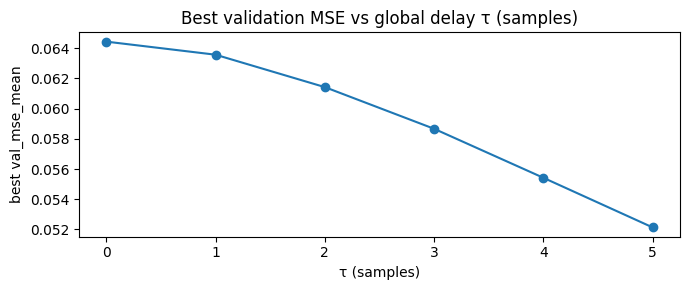

Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/tau_sweep_best_nnz.png


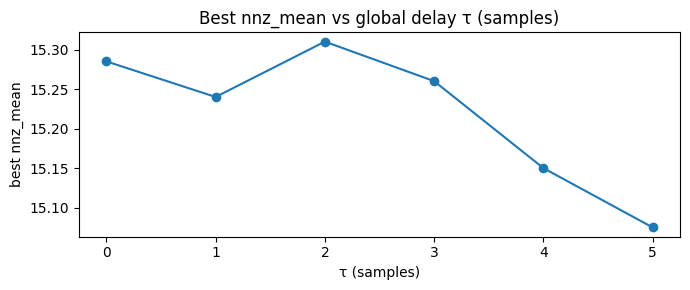

Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/tau_sweep_best_lam.png


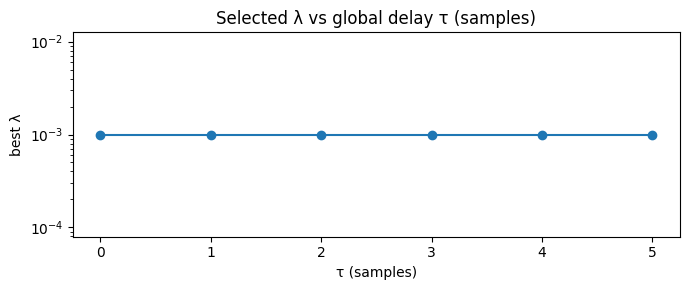

In [11]:
# Cell 11 — Global τ sweep (each τ does its own λ sweep, picks best, saves pack + summary)

def select_model_from_sweep(lam_grid, all_metrics, all_Xi, tol=1.05):
    val_mses = np.array([m["val_mse_mean"] for m in all_metrics])
    nnz_means = np.array([m["nnz_mean"] for m in all_metrics])

    best_val = val_mses.min()
    good = val_mses <= (tol * best_val)
    idx_best = np.where(good)[0][np.argmin(nnz_means[good])]

    return idx_best, all_Xi[idx_best], all_metrics[idx_best], best_val

def run_lambda_sweep_for_current_tau(cfg: NetSINDyConfig,
                                     X_tr, Xtau_tr, dX_tr,
                                     X_va, Xtau_va, dX_va,
                                     W, lam_grid):
    all_metrics, all_Xi = [], []
    for lam in lam_grid:
        Xi, names, met = fit_all_nodes(
            lam=lam,
            Xtr=X_tr, Xtau_tr=Xtau_tr, dXtr=dX_tr,
            Xva=X_va, Xtau_va=Xtau_va, dXva=dX_va,
            W=W, cfg=cfg
        )
        all_metrics.append(met)
        all_Xi.append(Xi)
    idx_best, Xi_best, met_best, best_val = select_model_from_sweep(lam_grid, all_metrics, all_Xi, tol=1.05)
    return {
        "lam_grid": [float(l) for l in lam_grid],
        "metrics": all_metrics,
        "idx_best": int(idx_best),
        "best": met_best,
        "Xi_best": Xi_best,
        "feature_names_example_node0": names  # for reference
    }

# ---- choose sweep ranges ----
tau_grid = [0, 1, 2, 3, 4, 5]          # in samples
lam_grid = np.logspace(-8, -2, 13)     # same as before (adjust if needed)

tau_results = []

# We must rebuild X_used / X_tau_used / derivatives for each τ because alignment changes
# We'll reuse X_raw (original z-scored) from Cell 3 by recomputing quickly here.
# Re-load X_raw and rebuild standardized X (so each τ is consistent)
X_raw = np.load(os.path.join(DATA_PROC, cfg.X_file))
if X_raw.shape[0] == W.shape[0]:
    X = X_raw.T
else:
    X = X_raw
X_mu = X.mean(axis=0, keepdims=True)
X_sd = X.std(axis=0, keepdims=True)
Xz_full = (X - X_mu) / (X_sd + 1e-12)

for tau in tau_grid:
    cfg_tau = NetSINDyConfig(**asdict(cfg))   # copy cfg
    cfg_tau.tau_samples = int(tau)

    # Align Xz and X_tau at this tau
    if tau == 0:
        Xz = Xz_full.copy()
        X_tau = Xz_full.copy()
    else:
        X_tau = Xz_full[:-tau, :]
        Xz = Xz_full[tau:, :]

    # Derivatives and aligned delayed predictors
    X_mid, dXdt = finite_difference_centered(Xz, cfg_tau.dt)
    Xtau_mid = X_tau[1:-1]

    # Split
    (X_tr, Xtau_tr, dX_tr), (X_va, Xtau_va, dX_va) = time_split(X_mid, Xtau_mid, dXdt, cfg_tau.train_frac)

    # Sweep λ for this τ
    pack = run_lambda_sweep_for_current_tau(cfg_tau, X_tr, Xtau_tr, dX_tr, X_va, Xtau_va, dX_va, W, lam_grid)

    tau_results.append({
        "tau_samples": int(tau),
        "tau_seconds": float(tau * cfg_tau.dt),
        "best": pack["best"],
        "idx_best": pack["idx_best"],
        "lam_grid": pack["lam_grid"],
        "metrics": pack["metrics"]
    })

    print(f"tau={tau}  best_lam={pack['best']['lam']:.1e}  best_val_mse={pack['best']['val_mse_mean']:.4f}  nnz_mean={pack['best']['nnz_mean']:.1f}")

# Save tau sweep summary
with open(os.path.join(OUT_DIR, "tau_sweep_summary.json"), "w") as f:
    json.dump({"tau_grid": tau_grid, "tau_results": tau_results}, f, indent=2)

print("Saved tau_sweep_summary.json")

# Quick plot: best val_mse vs tau (and nnz)
best_val = [r["best"]["val_mse_mean"] for r in tau_results]
best_nnz = [r["best"]["nnz_mean"] for r in tau_results]
best_lam = [r["best"]["lam"] for r in tau_results]

plt.figure(figsize=(7,3))
plt.plot(tau_grid, best_val, marker="o")
plt.title("Best validation MSE vs global delay τ (samples)")
plt.xlabel("τ (samples)")
plt.ylabel("best val_mse_mean")
plt.tight_layout()
save_fig("tau_sweep_best_valmse.png", OUT_DIR)
plt.show()

plt.figure(figsize=(7,3))
plt.plot(tau_grid, best_nnz, marker="o")
plt.title("Best nnz_mean vs global delay τ (samples)")
plt.xlabel("τ (samples)")
plt.ylabel("best nnz_mean")
plt.tight_layout()
save_fig("tau_sweep_best_nnz.png", OUT_DIR)
plt.show()

plt.figure(figsize=(7,3))
plt.plot(tau_grid, best_lam, marker="o")
plt.title("Selected λ vs global delay τ (samples)")
plt.xlabel("τ (samples)")
plt.ylabel("best λ")
plt.yscale("log")
plt.tight_layout()
save_fig("tau_sweep_best_lam.png", OUT_DIR)
plt.show()


Spearman corr (W vs |W_hat|) on structural edges: -0.7430117037654538
Spearman corr on selected edges only: -0.741744040504796 (n=2538)
Saved W_What_correlation.json
Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/W_hat_abs_heatmap.png


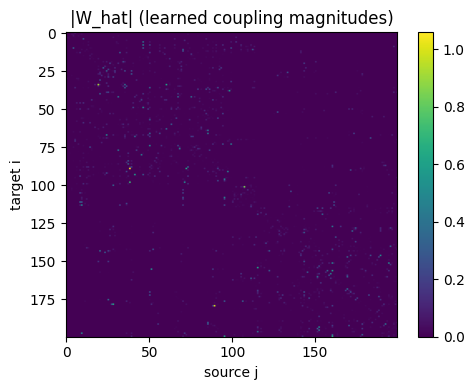

In [12]:
# Cell 12 — Quantify W vs |W_hat| (Spearman) and save one more diagnostic plot

def spearman_corr(a: np.ndarray, b: np.ndarray) -> float:
    """
    Spearman correlation without scipy:
    compute rank correlation via ranking then Pearson.
    """
    def rankdata(x):
        # simple average ranks for ties
        temp = x.argsort()
        ranks = np.empty_like(temp, dtype=float)
        ranks[temp] = np.arange(len(x), dtype=float)

        # handle ties: average ranks
        xs = x[temp]
        i = 0
        while i < len(x):
            j = i
            while j + 1 < len(x) and xs[j + 1] == xs[i]:
                j += 1
            if j > i:
                avg = (ranks[temp[i]] + ranks[temp[j]]) / 2.0
                ranks[temp[i:j+1]] = avg
            i = j + 1
        return ranks

    ra = rankdata(a)
    rb = rankdata(b)
    ra = (ra - ra.mean()) / (ra.std() + 1e-12)
    rb = (rb - rb.mean()) / (rb.std() + 1e-12)
    return float(np.mean(ra * rb))

# Use the best model already selected earlier in the notebook (Xi_best, W_hat)
mask_edges = (W != 0)
w_vals = W[mask_edges].ravel()
what_vals = np.abs(W_hat[mask_edges].ravel())

# Spearman on all structural edges
rho_all = spearman_corr(w_vals, what_vals)

# Spearman only where model kept coupling nonzero (selected edges)
mask_sel = what_vals > 0
rho_sel = spearman_corr(w_vals[mask_sel], what_vals[mask_sel]) if mask_sel.sum() > 5 else np.nan

print("Spearman corr (W vs |W_hat|) on structural edges:", rho_all)
print("Spearman corr on selected edges only:", rho_sel, f"(n={mask_sel.sum()})")

# Save these numbers
with open(os.path.join(OUT_DIR, "W_What_correlation.json"), "w") as f:
    json.dump(
        {"spearman_all_structural_edges": rho_all,
         "spearman_selected_edges_only": rho_sel,
         "n_structural_edges": int(mask_edges.sum()),
         "n_selected_edges": int(mask_sel.sum())},
        f, indent=2
    )
print("Saved W_What_correlation.json")

# Optional: heatmap of W_hat magnitude (can be big; but useful once)
plt.figure(figsize=(5,4))
plt.imshow(np.abs(W_hat), aspect="auto")
plt.title("|W_hat| (learned coupling magnitudes)")
plt.xlabel("source j")
plt.ylabel("target i")
plt.colorbar()
plt.tight_layout()
save_fig("W_hat_abs_heatmap.png", OUT_DIR)
plt.show()


tau=0  best_lam=1.0e-03  val_mse=0.0644  nnz_mean=15.3
tau=1  best_lam=1.0e-03  val_mse=0.0636  nnz_mean=15.2
tau=2  best_lam=1.0e-03  val_mse=0.0614  nnz_mean=15.3
tau=3  best_lam=1.0e-03  val_mse=0.0587  nnz_mean=15.3
tau=4  best_lam=1.0e-03  val_mse=0.0554  nnz_mean=15.2
tau=5  best_lam=1.0e-03  val_mse=0.0521  nnz_mean=15.1

FINAL CHOICE:
tau_final=5 samples  (0.1000 sec),  lam_final=1.00e-03
best metrics: {'lam': 0.001, 'train_mse_mean': 0.0117644087334026, 'val_mse_mean': 0.05213181567979247, 'nnz_mean': 15.075, 'nnz_median': 14.5, 'nnz_max': 37, 'nnz_per_node': [8, 17, 9, 12, 10, 9, 22, 11, 19, 12, 28, 15, 24, 23, 13, 13, 17, 18, 8, 18, 22, 7, 17, 12, 18, 17, 15, 15, 16, 13, 15, 14, 11, 12, 11, 14, 27, 11, 10, 25, 16, 9, 17, 14, 17, 10, 19, 8, 8, 21, 35, 13, 11, 16, 8, 9, 24, 21, 7, 11, 17, 8, 12, 17, 9, 16, 10, 29, 17, 18, 17, 12, 11, 12, 18, 21, 14, 18, 11, 18, 10, 19, 11, 8, 19, 19, 27, 12, 33, 16, 37, 13, 22, 13, 24, 14, 9, 14, 9, 20, 16, 21, 11, 15, 9, 23, 15, 11, 15, 14, 4

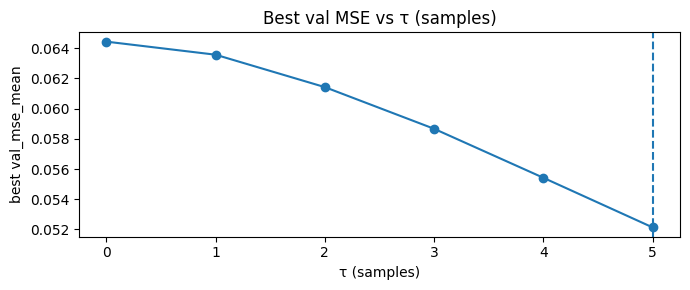

Saved figure: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/tau_sweep_best_nnz.png


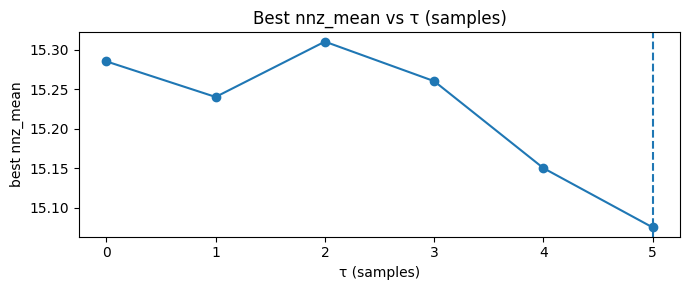

Saved config: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/config_network_sindy_Sch200_hopf_2026-01-01_101343.json


'/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/network_sindy_out_Sch200/config_network_sindy_Sch200_hopf_2026-01-01_101343.json'

In [13]:
# --- A) RUN τ SWEEP (global delay) and PICK FINAL τ (and λ) ---
# Drop this cell after Cell 12 (or replace your earlier tau-sweep cell with this cleaner version).

import os, json
import numpy as np
import matplotlib.pyplot as plt

# Choose sweep ranges
tau_grid = [0, 1, 2, 3, 4, 5]              # in samples
lam_grid = np.logspace(-8, -2, 13)         # same as before
tol = 1.05                                  # within 5% of best val → pick sparsest

# Reload standardized X once (consistent baseline for all τ)
X_raw = np.load(os.path.join(DATA_PROC, cfg.X_file))
if X_raw.shape[0] == W.shape[0]:
    X = X_raw.T
else:
    X = X_raw

X_mu = X.mean(axis=0, keepdims=True)
X_sd = X.std(axis=0, keepdims=True)
Xz_full = (X - X_mu) / (X_sd + 1e-12)

def select_idx(val_mses, nnz_means, tol=1.05):
    best_val = val_mses.min()
    good = val_mses <= (tol * best_val)
    idx = np.where(good)[0][np.argmin(nnz_means[good])]
    return idx, best_val

tau_packs = []

for tau in tau_grid:
    # Align X(t) with X(t-tau)
    if tau == 0:
        Xz = Xz_full.copy()
        X_tau = Xz_full.copy()
    else:
        X_tau = Xz_full[:-tau, :]
        Xz = Xz_full[tau:, :]

    # Derivatives
    X_mid, dXdt = finite_difference_centered(Xz, cfg.dt)
    Xtau_mid = X_tau[1:-1]

    # Split
    (X_tr, Xtau_tr, dX_tr), (X_va, Xtau_va, dX_va) = time_split(X_mid, Xtau_mid, dXdt, cfg.train_frac)

    all_metrics = []
    all_Xi = []

    for lam in lam_grid:
        Xi, names, met = fit_all_nodes(
            lam=float(lam),
            Xtr=X_tr, Xtau_tr=Xtau_tr, dXtr=dX_tr,
            Xva=X_va, Xtau_va=Xtau_va, dXva=dX_va,
            W=W, cfg=cfg
        )
        all_metrics.append(met)
        all_Xi.append(Xi)

    val_mses = np.array([m["val_mse_mean"] for m in all_metrics])
    nnz_means = np.array([m["nnz_mean"] for m in all_metrics])

    idx_best, best_val = select_idx(val_mses, nnz_means, tol=tol)
    best = all_metrics[idx_best]
    Xi_best_tau = all_Xi[idx_best]

    tau_packs.append({
        "tau_samples": int(tau),
        "tau_seconds": float(tau * cfg.dt),
        "best": best,
        "idx_best": int(idx_best),
        "lam_grid": [float(l) for l in lam_grid],
        "metrics": all_metrics
    })

    print(f"tau={tau}  best_lam={best['lam']:.1e}  val_mse={best['val_mse_mean']:.4f}  nnz_mean={best['nnz_mean']:.1f}")

# Pick final τ by lowest val MSE; tie-break by sparsity (nnz_mean)
best_vals = np.array([p["best"]["val_mse_mean"] for p in tau_packs])
best_nnz = np.array([p["best"]["nnz_mean"] for p in tau_packs])
tau_arr = np.array([p["tau_samples"] for p in tau_packs])

# First: within 2% of minimum val, pick sparsest
min_val = best_vals.min()
good = best_vals <= 1.02 * min_val
idx_tau_final = np.where(good)[0][np.argmin(best_nnz[good])]

tau_final = int(tau_arr[idx_tau_final])
lam_final = float(tau_packs[idx_tau_final]["best"]["lam"])
print("\nFINAL CHOICE:")
print(f"tau_final={tau_final} samples  ({tau_final*cfg.dt:.4f} sec),  lam_final={lam_final:.2e}")
print("best metrics:", tau_packs[idx_tau_final]["best"])

# Save sweep summary
with open(os.path.join(OUT_DIR, "tau_sweep_summary.json"), "w") as f:
    json.dump({"tau_grid": tau_grid, "tau_packs": tau_packs,
               "tau_final": tau_final, "lam_final": lam_final}, f, indent=2)
print("Saved tau_sweep_summary.json")

# Plot best val vs tau and nnz vs tau
plt.figure(figsize=(7,3))
plt.plot(tau_grid, best_vals, marker="o")
plt.axvline(tau_final, linestyle="--")
plt.title("Best val MSE vs τ (samples)")
plt.xlabel("τ (samples)")
plt.ylabel("best val_mse_mean")
plt.tight_layout()
save_fig("tau_sweep_best_valmse.png", OUT_DIR)
plt.show()

plt.figure(figsize=(7,3))
plt.plot(tau_grid, best_nnz, marker="o")
plt.axvline(tau_final, linestyle="--")
plt.title("Best nnz_mean vs τ (samples)")
plt.xlabel("τ (samples)")
plt.ylabel("best nnz_mean")
plt.tight_layout()
save_fig("tau_sweep_best_nnz.png", OUT_DIR)
plt.show()

# IMPORTANT: update cfg to the final τ and λ for the rest of the notebook (if you want)
cfg.tau_samples = tau_final
cfg.lam = lam_final
save_config(cfg, OUT_DIR)
